In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import time

In [0]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, phi, layers):
        
        X = np.concatenate([x, y], 1)
        self.x = x
        self.y = y
        self.lb = X.min(0)
        self.ub = X.max(0)

        self.phi = phi

        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, y.shape[1]])

        self.phi_tf = tf.placeholder(tf.float32, shape=[None, phi.shape[1]])
        
        #self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)
        self.phi_pred, self.phi_xx_pred, self.phi_yy_pred = self.net_NS(self.x_tf, self.y_tf)

        self.loss = tf.reduce_sum((self.phi_tf - self.phi_pred)**2) + \
                        tf.reduce_sum(tf.square(self.phi_xx_pred+self.phi_yy_pred))
                    
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 10000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_NS(self, x, y):
        phi = self.neural_net(tf.concat([x,y], 1), self.weights, self.biases)
        
        #sess = tf.Session()

        phi_x = tf.gradients(phi, x)[0]
        phi_y = tf.gradients(phi, y)[0]  
        
        phi_xx = tf.gradients(phi_x, x)[0]
        phi_yy = tf.gradients(phi_y, y)[0]
        
        return phi, phi_xx, phi_yy
    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))
      
    def train(self, nIter): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y,
                   self.phi_tf: self.phi}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print(f"elapased time:{time.time()-start_time}")
                start_time = time.time()
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback
                                )
            
    
    def predict(self, x_star, y_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star}
        
        phi_star = self.sess.run(self.phi_pred, tf_dict)

        
        return phi_star

(10000, 1)
(100,)


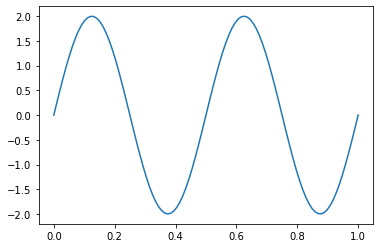

(10000, 1)
(396, 1)
(396, 1)
(396, 1)


In [0]:
X = np.arange(0, 1, 0.01)
nx = X.shape[0]
Y = np.arange(0, 1, 0.01)
ny = Y.shape[0]
XX, YY = np.meshgrid(X, Y)
XX = XX.flatten()[:, None]
YY = YY.flatten()[:, None]
bc_x_l = XX==0
print(bc_x_l.shape)
print(XX[bc_x_l].shape)
bc_x_r = XX==np.max(X)
phi_r = 2*np.sin(np.linspace(0,1,nx)*4*np.pi)
plt.plot(np.linspace(0,1,nx), phi_r)
plt.show()
#phi_r = torch.tensor(phi_r, dtype=torch.float32)
bc_y_d = YY==0
bc_y_u = (YY==np.max(YY))&(~bc_x_l)&(~bc_x_r)
bc = (bc_x_l|bc_x_r|bc_y_d|bc_y_u).squeeze(1)


# phiのデータを作る
phi = np.zeros(XX.shape[0])[:,None]
print(phi.shape)
phi[bc_x_l]=0
phi[bc_y_d]=0
phi[bc_x_r]=2*np.sin(np.linspace(0,1,ny)*4*np.pi)
#phi[bc_x_r]=1
phi[bc_y_u]=2


# BC
x_train = XX[bc, :]
y_train = YY[bc, :]
phi_train = phi[bc, :]
print(x_train.shape)
print(y_train.shape)
print(phi_train.shape)

In [0]:
layers = [2, 20, 20, 20, 20,  1]
model = PhysicsInformedNN(x_train, y_train ,phi_train, layers)
model.train(10000)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

elapased time:2.9797651767730713
elapased time:0.09961819648742676
elapased time:0.09314823150634766
elapased time:0.09784889221191406
elapased time:0.09441471099853516
elapased time:0.08743691444396973
elapased time:0.09154415130615234
elapased time:0.10112714767456055
elapased time:0.08773541450500488
elapased time:0.08700108528137207
elapased time:0.10178375244140625
elapased time:0.09096002578735352
elapased time:0.09545063972473145
elapased time:0.10474061965942383
elapased time:0.0957942008972168
elapased time:0.10723114013671875
elapased time:0.11061882972717285
elapased time:0.10517716407775879
elapased time:0.09441280364990234
elapased time:0.09583282470703125
elapased time:0.09

(10000, 1)


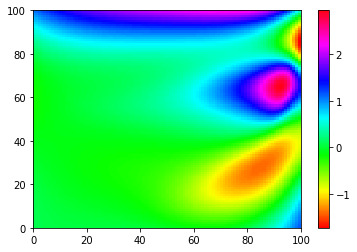

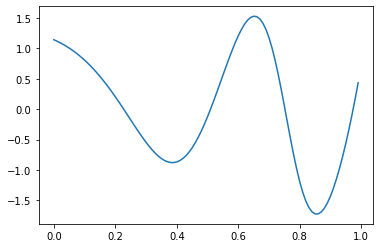

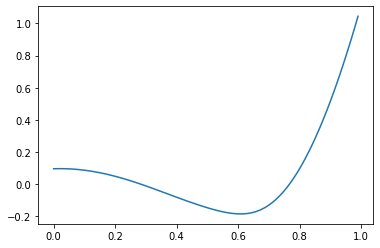

In [0]:
X_star = XX
Y_star = YY
phi_pred = model.predict(X_star, Y_star)
print(phi_pred.shape)
phi_pred = phi_pred.reshape(ny, nx)

fig, ax = plt.subplots()
heatmap = ax.pcolor(phi_pred, cmap='hsv')
fig.colorbar(heatmap, ax=ax)
plt.show()

# x=199
phi_x199 = phi_pred[:, 99]
plt.plot(Y, phi_x199)
plt.show()

# x=0
phi_x0 = phi_pred[:,0]
plt.plot(Y, phi_x0)
plt.show()

iteration No = 0 delta= 1.0
iteration No = 100 delta= 0.004842781541445573
iteration No = 200 delta= 0.002420701462174324
iteration No = 300 delta= 0.0016123736469536576
iteration No = 400 delta= 0.0012073464482272867


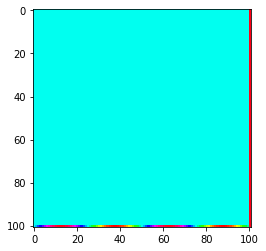

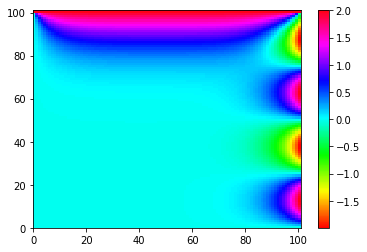

In [0]:
"""
ラプラス方程式: 数値解法, ヤコビ(Jacobi)法: 
12 Aug. 2017
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation # アニメーション作成のためのメソッドをインポート

fig = plt.figure()
anim = [] 

# 
delta_L=0.01  # グリッド幅
LL = 1 # 正方形の幅
L = int(LL/delta_L)

V = 5.0 # 1辺の境界の電位
convegence_criterion = 10**-3  # 収束条件。 精度を上げるならこの値を小さくする。

phi = np.zeros([L+1,L+1])
phi[0,:] = 0 # 境界条件
phi[:, 0] = 0
phi[-1, :] = 2*np.sin(np.linspace(0, LL, L+1)*4*np.pi)
phi[:, -1] = 2
phi2 = np.empty([L+1,L+1])

#for plot
im=plt.imshow(phi,cmap='hsv')
anim.append([im])


# メイン
delta = 1.0
n_iter=0
conv_check=[]
while delta > convegence_criterion:
    if n_iter % 100 ==0:  # 収束状況のモニタリング
        print("iteration No =", n_iter, "delta=",delta)
    conv_check.append([n_iter, delta])
    for i in range(L+1):
        for j in range(L+1):
            if i ==0 or i ==L or j==0 or j==L:
                phi2[i,j] = phi[i,j]
            else: 
                phi2[i,j] = (phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1])/4 # 補遺:式(11)を参照
    delta = np.max(abs(phi-phi2))

    phi, phi2 = phi2, phi
    n_iter+=1

    #im=plt.imshow(phi,cmap='hsv')
    #anim.append([im])

#for plot        
#plt.colorbar () # カラーバーの表示 
#plt.xlabel('X')
#plt.ylabel('Y')
#ani = ArtistAnimation(fig, anim, interval=100, blit=True,repeat_delay=1000)
#ani.save("t.gif", writer='imagemagick') 
# plot
fig, ax = plt.subplots()
phi = phi.T
heatmap = ax.pcolor(phi, cmap='hsv')
fig.colorbar(heatmap, ax=ax)
plt.show()

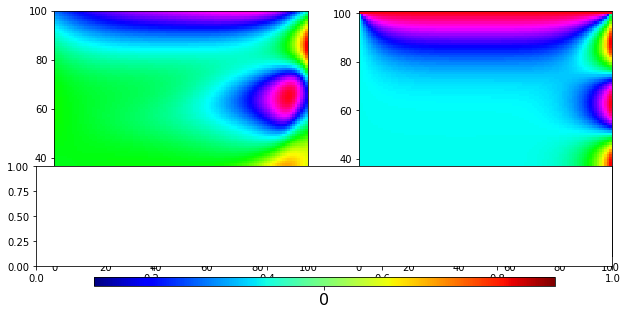

In [0]:
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
fs_suptitle  = 20
fs_title     = 16
fs_graticule = 12
fs_cbar      = 16

vmin, vmax = 0, 1200      ## colormap's range
cmap = plt.cm.jet

ticks = range(0,1201,200)    ## locations of labels of colorbar
ticklabels = ticks  
fig, axes = plt.subplots(1,2,figsize=(10,4.5))

axes[0].pcolor(phi_pred, cmap='hsv')
axes[1].pcolor(phi, cmap='hsv')
cmap = plt.cm.jet
## make mappable object for colorbar
norm = colors.Normalize(vmin=-2,vmax=2)
mappable = ScalarMappable(cmap=cmap,norm=norm)
mappable._A = []

## draw common colorbar
cb = fig.colorbar(mappable,ax=ax,aspect=50,pad=0.08,
                  shrink=0.8,orientation='horizontal')
cb.ax.tick_params(labelsize=fs_cbar)
cb.set_ticks(ticks)
cb.set_ticklabels(ticklabels)

plt.show()